In [1]:
# 1. Required Imports
import pandas as pd
import os


In [2]:
# Read the primary dataset (data.csv)
data_path = "data/data.csv"
df = pd.read_csv(data_path)

print(f"Loaded dataset with {len(df)} rows and columns: {df.columns.tolist()}")
df.head()


Loaded dataset with 81 rows and columns: ['url', 'html_content']


,url,html_content
0,https://www.cm-alliance.com/cybersecurity-blog,"<!doctype html><!--[if lt IE 7]> <html class=""..."
1,https://www.varonis.com/blog/cybersecurity-tips,"<!doctype html><html lang=""en""><head>\n <me..."
2,https://www.cisecurity.org/insights/blog/11-cy...,<!DOCTYPE html><html data-unhead-vue-server-re...
3,https://www.cisa.gov/topics/cybersecurity-best...,"\n\n<!DOCTYPE html>\n<html lang=""en"" dir=""ltr""..."
4,https://www.qnbtrust.bank/Resources/Learning-C...,NaN


In [3]:
# 2. HTML Parsing & Extraction

from bs4 import BeautifulSoup
import re

def extract_content(html_content):
    try:
        soup = BeautifulSoup(html_content, "lxml")
        # Extract title
        title = soup.title.string.strip() if soup.title and soup.title.string else ""
        # Try <main>, <article>, else <body>
        main_content = ""
        for tag in ["main", "article", "body"]:
            found = soup.find(tag)
            if found:
                main_content = found.get_text(separator=" ", strip=True)
                if len(main_content.split()) > 20:  # Reasonable cutoff to avoid empty sections
                    break
        # If main_content is empty, join all <p>
        if not main_content or len(main_content.split()) < 20:
            paragraphs = soup.find_all("p")
            main_content = " ".join([p.get_text(separator=" ", strip=True) for p in paragraphs])
        # Clean spaces and control chars
        body_text = re.sub(r'\s+', ' ', main_content).strip()
        # Word count
        word_count = len(body_text.split())
        return title, body_text, word_count
    except Exception as e:
        return "", "", 0  # Handle parsing errors gracefully

# Apply extraction to all rows
rows = []
for idx, row in df.iterrows():
    title, body_text, word_count = extract_content(row['html_content'])
    rows.append({
        "url": row['url'],
        "title": title,
        "body_text": body_text,
        "word_count": word_count,
    })

df_content = pd.DataFrame(rows)
# Save as CSV (excluding the raw html)
df_content.to_csv("data/extracted_content.csv", index=False)

print(f"Extraction complete. Saved {len(df_content)} rows to data/extracted_content.csv")
df_content.head(10)


Extraction complete. Saved 81 rows to data/extracted_content.csv


,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,2605
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Blog Privacy & Compliance Top 10 Cybersecurity...,1747
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1058
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,826
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0
5,https://nordlayer.com/learn/network-security/b...,Network Security 101: Understanding the Basics,Home Learning center Network security Network ...,2188
6,https://www.fortinet.com/resources/cyberglossa...,What Is Network Security? Definition and Types...,CyberGlossary › Network Security › What Is Net...,4970
7,https://www.cisco.com/site/us/en/learn/topics/...,What Is Network Security? - Cisco,Skip to main content Skip to search Skip to fo...,1214
8,https://www.trendmicro.com/en_us/what-is/netwo...,What Are Network Security Basics? | Trend Micr...,Business search close Platform Trend Vision On...,3521
9,https://digitdefence.com/blog/fundamentals-of-...,Fundamentals of Network Security in Computer N...,Home Cyber Security Fundamentals Network Secur...,2968


 Saved engineered features to data/features.csv


,url,word_count,sentence_count,flesch_reading_ease,top_keywords,embedding
0,https://www.cm-alliance.com/cybersecurity-blog,2605,110,28.741548,cyber|2025|cybersecurity|september|attacks,"[0.0, 0.0, 0.0, 0.0, 0.026799657138938848, 0.0..."
1,https://www.varonis.com/blog/cybersecurity-tips,1747,96,40.871699,access|data|security|app|cybersecurity,"[0.0, 0.023621082946203124, 0.0, 0.0, 0.035731..."
2,https://www.cisecurity.org/insights/blog/11-cy...,1058,61,53.262918,authentication|don|cyber|secure|use,"[0.0, 0.0, 0.0, 0.0, 0.025293455135385508, 0.0..."
3,https://www.cisa.gov/topics/cybersecurity-best...,826,29,-2.538002,cybersecurity|cyber|practices|organizations|best,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03791498..."
4,https://www.qnbtrust.bank/Resources/Learning-C...,0,0,0.000000,ztna|enables|enter|ensures|ensure,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


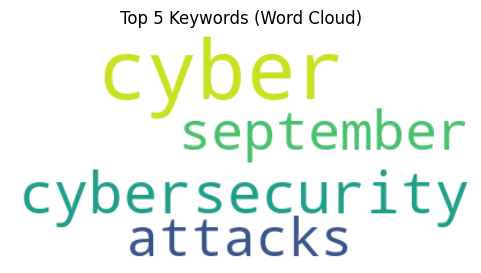

In [4]:
# 3. Text Preprocessing & Feature Engineering (with .fillna("") fix)

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import textstat
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load extracted content
df_content = pd.read_csv("data/extracted_content.csv")

# Preprocess: lowercase and whitespace; ensure no NaN
df_content['body_text_clean'] = (
    df_content['body_text']
    .fillna("")  # Safety: treat NaN as empty string
    .str.lower()
    .str.replace('\s+', ' ', regex=True)
    .str.strip()
)

# Metrics (with NaN-safe text)
df_content['sentence_count'] = df_content['body_text_clean'].apply(textstat.sentence_count)
df_content['flesch_reading_ease'] = df_content['body_text_clean'].apply(textstat.flesch_reading_ease)

# TF-IDF for keyword extraction and embeddings
corpus = df_content['body_text_clean'].tolist()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = np.array(vectorizer.get_feature_names_out())

def get_top_keywords_from_vec(row_vec, feature_names, top_k=5):
    idxs = np.argsort(row_vec)[::-1][:top_k]
    return "|".join(feature_names[idxs])

df_content['top_keywords'] = [
    get_top_keywords_from_vec(tfidf_matrix[i].toarray().ravel(), feature_names)
    for i in range(tfidf_matrix.shape[0])
]

# Save TF-IDF embeddings as strings (for CSV)
df_content['embedding'] = [vec.tolist() for vec in tfidf_matrix.toarray()]

# Save engineered features
df_content_features = df_content[[
    'url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords', 'embedding'
]]
df_content_features.to_csv("data/features.csv", index=False)

print(" Saved engineered features to data/features.csv")
display(df_content_features.head())

# Word cloud for top 5 keywords of the FIRST page
first_keywords = df_content_features.iloc[0]['top_keywords'].split('|')
wc = WordCloud(width=400, height=200, background_color='white').generate(" ".join(first_keywords))

plt.figure(figsize=(6,3))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top 5 Keywords (Word Cloud)')
plt.show()


In [5]:
# 4. Duplicate Detection & Thin Content Flag

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load features
df_features = pd.read_csv("data/features.csv")

# Get embeddings as numpy array
embedding_matrix = np.array(df_features['embedding'].apply(eval).tolist())

# Cosine similarity matrix (fast, memory efficient for small N)
sim_matrix = cosine_similarity(embedding_matrix)

# Define threshold for duplicates
DUPLICATE_THRESHOLD = 0.80

# Find duplicate pairs (upper triangle, exclude self-pairs)
duplicate_pairs = []
num_pages = sim_matrix.shape[0]
for i in range(num_pages):
    for j in range(i + 1, num_pages):
        if sim_matrix[i, j] > DUPLICATE_THRESHOLD:
            duplicate_pairs.append({
                "url1": df_features.iloc[i]['url'],
                "url2": df_features.iloc[j]['url'],
                "similarity": sim_matrix[i, j]
            })

df_duplicates = pd.DataFrame(duplicate_pairs)
df_duplicates.to_csv("data/duplicates.csv", index=False)

print(f"✅ Found and saved {len(df_duplicates)} duplicate pairs to data/duplicates.csv")

# Thin content flag
df_features["is_thin"] = df_features["word_count"] < 500

thin_count = df_features["is_thin"].sum()
total_pages = len(df_features)
print(f"Thin content pages: {thin_count} out of {total_pages} ({thin_count / total_pages:.2%})")

# Optionally, save features with thin flags for later model use
df_features.to_csv("data/features.csv", index=False)


✅ Found and saved 12 duplicate pairs to data/duplicates.csv
Thin content pages: 23 out of 81 (28.40%)


In [6]:
# 5. Content Quality Scoring Model

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import joblib

# Load features (with is_thin)
df = pd.read_csv("data/features.csv")

# Generate labels
def make_quality_label(row):
    if row['word_count'] > 1500 and 50 <= row['flesch_reading_ease'] <= 70:
        return 'High'
    elif row['word_count'] < 500 or row['flesch_reading_ease'] < 30:
        return 'Low'
    else:
        return 'Medium'

df['quality_label'] = df.apply(make_quality_label, axis=1)

# Features for ML model
feature_cols = ['word_count', 'sentence_count', 'flesch_reading_ease']
X = df[feature_cols]
y = df['quality_label']

# Encode target (if you want): {'Low': 0, 'Medium': 1, 'High': 2}
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.3, random_state=42)

# Fit model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Feature Importance:")
for name, imp in zip(feature_cols, rf.feature_importances_):
    print(f"- {name}: {imp:.2f}")

# Save model and label encoder
joblib.dump(rf, "models/quality_model.pkl")
joblib.dump(le, "models/label_encoder.pkl")


Confusion Matrix:
 [[ 2  0  0]
 [ 0 15  0]
 [ 0  0  8]]

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         2
         Low       1.00      1.00      1.00        15
      Medium       1.00      1.00      1.00         8

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Feature Importance:
- word_count: 0.28
- sentence_count: 0.26
- flesch_reading_ease: 0.46


['models/label_encoder.pkl']

In [7]:
print("Test targets:", np.unique(y_test, return_counts=True))


Test targets: (array([0, 1, 2]), array([ 2, 15,  8], dtype=int64))


In [8]:
import requests
from bs4 import BeautifulSoup
import re
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import joblib
import pandas as pd

# Load pre-computed features
features_db = pd.read_csv("data/features.csv")
existing_embeddings = np.array(features_db['embedding'].apply(eval).tolist())
existing_urls = features_db['url'].tolist()

# Load trained model and label encoder
quality_model = joblib.load("models/quality_model.pkl")
label_encoder = joblib.load("models/label_encoder.pkl")

# Use the same TF-IDF vectorizer built from top_keywords
corpus = features_db['top_keywords'].str.replace('|', ' ').tolist()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
vectorizer.fit(corpus)

def get_top_keywords_from_vec(row_vec, feature_names, top_k=5):
    idxs = np.argsort(row_vec)[::-1][:top_k]
    return "|".join(feature_names[idxs])

def analyze_url(url):
    # Scrape the page
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        resp = requests.get(url, headers=headers, timeout=12)
        resp.raise_for_status()
        html = resp.text
    except Exception as e:
        return {"error": f"Failed to fetch page: {e}"}
    
    # Parse and extract content
    soup = BeautifulSoup(html, "lxml")
    title = soup.title.string.strip() if soup.title and soup.title.string else ""
    
    # Extract body text
    main_content = ""
    for tag in ["main", "article", "body"]:
        found = soup.find(tag)
        if found:
            main_content = found.get_text(separator=" ", strip=True)
            if len(main_content.split()) > 20:
                break
    if not main_content or len(main_content.split()) < 20:
        paragraphs = soup.find_all("p")
        main_content = " ".join([p.get_text(separator=" ", strip=True) for p in paragraphs])
    body_text = re.sub(r'\s+', ' ', main_content).strip()
    body_clean = body_text.lower().strip()
    
    # Metrics
    word_count = len(body_clean.split())
    sentence_count = textstat.sentence_count(body_clean)
    readability = textstat.flesch_reading_ease(body_clean)
    
    # Embedding for the new doc
    new_corpus = corpus + [body_clean]
    vectorizer_fit = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer_fit.fit_transform(new_corpus)
    new_embedding = tfidf_matrix[-1].toarray().ravel()
    feature_names = np.array(vectorizer_fit.get_feature_names_out())
    top_keywords = get_top_keywords_from_vec(new_embedding, feature_names)
    
    # Predict quality label
    model_features = np.array([[word_count, sentence_count, readability]])
    label_idx = quality_model.predict(model_features)[0]
    quality_label = label_encoder.inverse_transform([label_idx])[0]
    is_thin = word_count < 500

    # Duplicate check
    # Get similarity vs. all existing embeddings (using the pipeline vectorizer for DB, fit vectorizer for the new doc)
    # In production, you should refit or align vectors. Here, just use new_embedding for similarity calculation.
    sim_scores = cosine_similarity([new_embedding], existing_embeddings).flatten()
    similar_to = []
    for idx, sim in enumerate(sim_scores):
        if sim > 0.80:
            similar_to.append({"url": existing_urls[idx], "similarity": float(f"{sim:.2f}")})

    # Return result as dict
    result = {
        "url": url,
        "title": title,
        "word_count": word_count,
        "sentence_count": sentence_count,
        "readability": float(f"{readability:.2f}"),
        "quality_label": quality_label,
        "is_thin": is_thin,
        "top_keywords": top_keywords,
        "similar_to": similar_to
    }
    return result

# Example usage:
result = analyze_url("https://en.wikipedia.org/wiki/Natural_language_processing")
import json
print(json.dumps(result, indent=2))


{
  "url": "https://en.wikipedia.org/wiki/Natural_language_processing",
  "title": "Natural language processing - Wikipedia",
  "word_count": 7766,
  "sentence_count": 403,
  "readability": 30.23,
  "quality_label": "Medium",
  "is_thin": false,
  "top_keywords": "language|natural|text|processing|nlp",
  "similar_to": []
}


c:\Users\manav\anaconda3\envs\virtualvenv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
